# Homework 3

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# 1. Modeling Volatility and VaR

## Data

Find the data file `spy_data.xlsx`.

* Use the returns on the S&P 500 (`SPY`) and 1-month T-bills (`^IRX`).

* Calculate the excess market returns, using the treasury rate as the risk-free rate.

***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

In [2]:
return_df = pd.read_excel('../data/spy_data.xlsx', sheet_name='total returns').ffill()
return_df['date'] = pd.to_datetime(return_df['date'])
return_df = return_df.set_index('date')
return_df['Excess return'] = return_df['SPY'] - return_df['^IRX']

display(return_df.head(3))

,SPY,^IRX,Excess return
date,,,
1994-01-04,0.004035,0.000122,0.003913
1994-01-05,0.002009,0.000122,0.001888
1994-01-06,0.000000,0.000121,-0.000121


## 1.1 Historic VaR.
Starting at `Jan 2, 2001`, calculate the historic-based VaR, based on the expanding sample from the first date through `Dec 29, 2000`. 

Denote $\tilde{r}^{VaR, 0.05}_{t}$ as the estimate of the time-t VaR based on data through $t − 1$.

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* Plot $\tilde{r}^{VaR, 0.05}_{t}$ over time.

* Report the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$. Compare this to the quantile of $.05$.

* What drawbacks do you see in this historic VaR?

#### Note
By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time $t − 1$. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

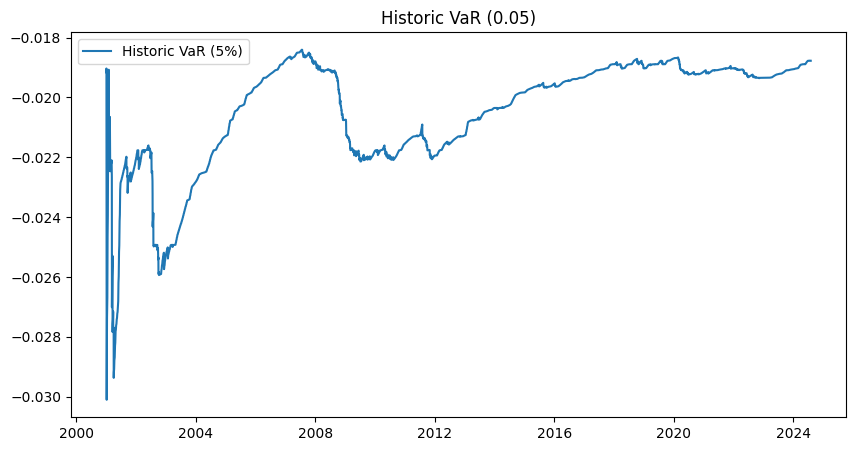

In [3]:
return_df = return_df[pd.to_datetime('2000-12-29'): ]
return_df['Historical VaR'] = return_df['Excess return'].expanding().quantile(0.05).shift(1)

plt.figure(figsize=(10, 5))
plt.plot(return_df[pd.to_datetime('2001-1-2'):].index, return_df['Historical VaR'][pd.to_datetime('2001-1-2'):], label='Historic VaR (5%)')
plt.legend()
plt.title('Historic VaR (0.05)')
plt.show()

In [4]:
violations = return_df[return_df['Excess return'] < return_df['Historical VaR']]
frequency = len(violations) / len(return_df)

print(f"Frequency of VaR violations: {frequency:.4%}")

Frequency of VaR violations: 4.0148%


- Resulting lag issue as base on too old data to formulate the model.
- Take equal weight for previous data to measure the risk, which is not reasonable to capture recent impact

***

## 1.2 Volatility
We will calculate a time-series of volatility estimates using a few different methods. For each, we use $\sigma_t$ to denote our estimate of the time-t return volatility.

#### Expanding Series

$$
\sigma^2_{t,expanding} = \frac{1}{t-1}\sum_{\tau = 1}^{t-1}\tilde{r}^2_{\tau}
$$



#### Rolling Window

$$
\sigma^2_{t,rolling} = \frac{1}{m}\sum_{l = 1}^{m}\tilde{r}^2_{t-l}
$$

Use $m=$`252`.


#### Exponentially Weighted Moving Average (EWMA)

Feel free to calculate the EWMA using the following recursion,
$$
\sigma^2_{t, EWMA} = \theta \sigma^2_{t-1, EWMA} + (1-\theta)\tilde{r}^2_{t-1}
$$

Rather than estimating $\theta$, simply use $\theta$ = 0.94, and initialize with 
$$\sigma_{t_0} = \frac{0.20}{\sqrt{252}}$$

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* For each of these three methods, plot $\sigma_t$. (Plot the vol, not the variance.)

* For each method, calculate the 5th percentile, 1-day-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping $\mu$ from that formula, and rounding the normal distribution z-score to -1.65.
$$\tilde{r}^{VaR, 0.05}_{t} = −1.65 \sigma_t$$

* For each of these vol-based VaR estimates, calculate the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$

* Compare and contrast your results among each other and relative to the historic method in the previous problem.

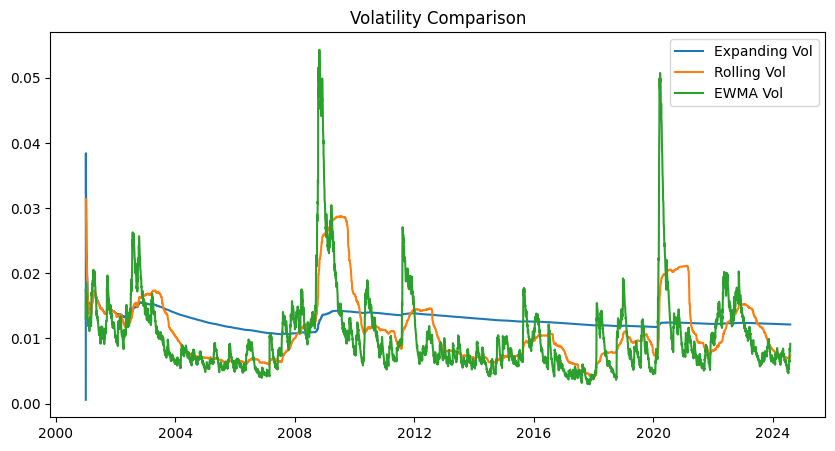

In [5]:
return_df['Expanding Vol'] = return_df['Excess return'].expanding().std(ddof=1).shift(1)
return_df['Rolling Vol'] = return_df['Excess return'].rolling(252, 3).std(ddof=0).shift(1)

theta = 0.94
ewma_vol = np.zeros(len(return_df))
ewma_vol[0] = 0.2 / np.sqrt(252)
for t in range(1, len(return_df)):
    ewma_vol[t] = np.sqrt(
        theta * ewma_vol[t - 1]**2 + (1 - theta) * return_df['Excess return'].iloc[t - 1]**2)
    
return_df['EWMA Vol'] = ewma_vol

plt.figure(figsize=(10, 5))
plt.plot(return_df[pd.to_datetime('2001-1-2'):].index, return_df['Expanding Vol'][pd.to_datetime('2001-1-2'):], label='Expanding Vol')
plt.plot(return_df[pd.to_datetime('2001-1-2'):].index, return_df['Rolling Vol'][pd.to_datetime('2001-1-2'):], label='Rolling Vol')
plt.plot(return_df[pd.to_datetime('2001-1-2'):].index, return_df['EWMA Vol'][pd.to_datetime('2001-1-2'):], label='EWMA Vol')

plt.legend()
plt.title('Volatility Comparison')
plt.show()

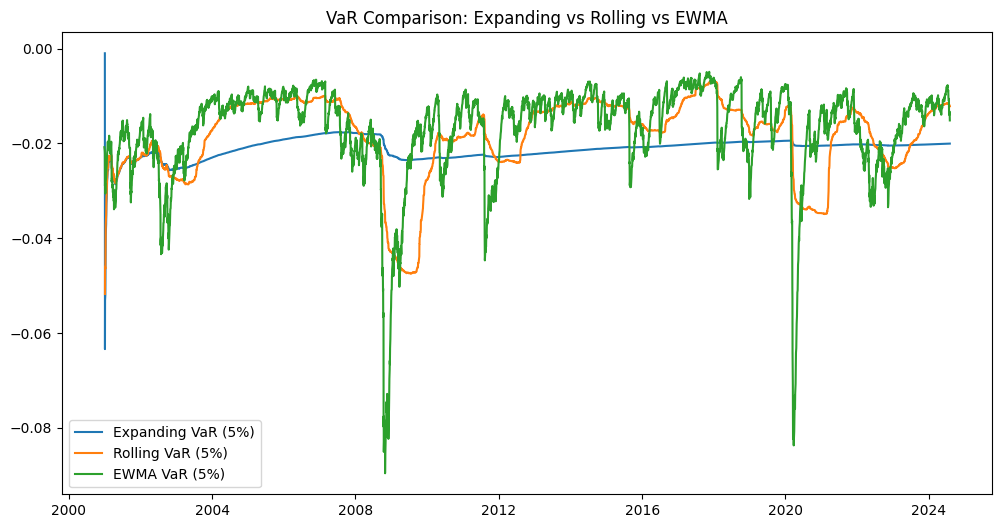

In [6]:
z_score = -1.65
return_df['VaR_Expanding'] = z_score * return_df['Expanding Vol']
return_df['VaR_Rolling'] = z_score * return_df['Rolling Vol']
return_df['VaR_EWMA'] = z_score * return_df['EWMA Vol']

plt.figure(figsize=(12, 6))
plt.plot(return_df.index, return_df['VaR_Expanding'], label='Expanding VaR (5%)')
plt.plot(return_df.index, return_df['VaR_Rolling'], label='Rolling VaR (5%)')
plt.plot(return_df.index, return_df['VaR_EWMA'], label='EWMA VaR (5%)')
plt.legend()
plt.title('VaR Comparison: Expanding vs Rolling vs EWMA')
plt.show()

In [7]:
def calculate_violation_frequency(return_series, var_series):
    violations = return_series < var_series
    frequency = violations.sum() / len(violations)
    return frequency

expanding_freq = calculate_violation_frequency(return_df['Excess return'], return_df['VaR_Expanding'])
rolling_freq = calculate_violation_frequency(return_df['Excess return'], return_df['VaR_Rolling'])
ewma_freq = calculate_violation_frequency(return_df['Excess return'], return_df['VaR_EWMA'])

print(f"Expanding Vol-based VaR violation frequency: {expanding_freq:.4%}")
print(f"Rolling Vol-based VaR violation frequency: {rolling_freq:.4%}")
print(f"EWMA Vol-based VaR violation frequency: {ewma_freq:.4%}")

Expanding Vol-based VaR violation frequency: 3.6606%
Rolling Vol-based VaR violation frequency: 5.2969%
EWMA Vol-based VaR violation frequency: 5.9885%


- Expanding method takes too many old data that is a relatively smooth estimator compared to other two
- EWMA can place more weight to the recent data hence can capture the recent effect more accurately
- EWMA can capture more points break VaR boundary compared to other two, and Expanding method caputures the least

***

## 1.3 CVaR
Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for $q =$ `.05`.) 

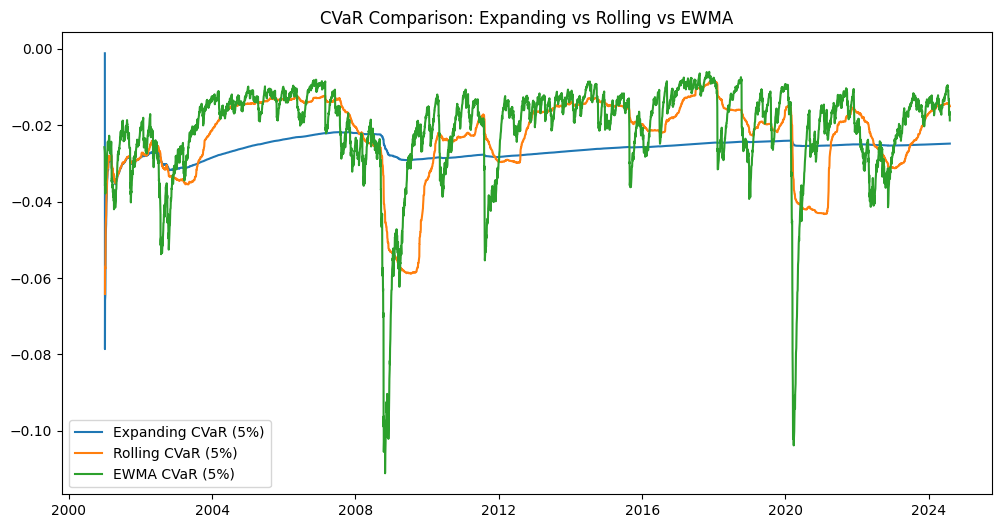

In [9]:
return_df['CVaR_Expanding'] = -norm.pdf(z_score) / 0.05 * return_df['Expanding Vol']
return_df['CVaR_Rolling'] = -norm.pdf(z_score) / 0.05 * return_df['Rolling Vol']
return_df['CVaR_EWMA'] = -norm.pdf(z_score) / 0.05 * return_df['EWMA Vol']

plt.figure(figsize=(12, 6))
plt.plot(return_df.index, return_df['CVaR_Expanding'], label='Expanding CVaR (5%)')
plt.plot(return_df.index, return_df['CVaR_Rolling'], label='Rolling CVaR (5%)')
plt.plot(return_df.index, return_df['CVaR_EWMA'], label='EWMA CVaR (5%)')
plt.legend()
plt.title('CVaR Comparison: Expanding vs Rolling vs EWMA')
plt.show()

***

## 1.4 GARCH

#### EXTRA: Not Submitted, not covered in Midterm 1

Re-do the VaR and CVaR calculations using a normal model with volatility calculated from a GARCH(1,1).

To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine. You should be familiar with EWMA and GARCH from the August Review.